# Multi Armed Bandit
- 다양한 모델을 동시에 사용하여 아이템을 추천 받았을 때, 어떤 모델이 가장 효과적인 아이템을 추천하는지 확인할 수 있는 방법입니다.

In [70]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt

plt.style.use("dark_background")

## 모형에 따라, 고객의 클릭 유무를 알려주는 클래스
- 우리에게는 3가지 추천 모형이 있습니다. 세 추천 모형 모두 고객이 관심가질만한 제품을 노출시켜, 클릭을 유도하기 위해 설계되어 있습니다. 즉 높은 클릭율(CTR)일수록 좋은 모형입니다. 하지만 우리는 셋 중 어느 모형이 높은 CTR을 보일지 모릅니다. 이 때 우리는 어떻게 시도하는 것이 좋을까요?

In [8]:
gdd.download_file_from_google_drive(file_id="1CmnFuDTSAaNxbZDkaBa1OtcVmTTnTsAY", dest_path="./MAB_simulation.csv")
ads_df = pd.read_csv("MAB_simulation.csv")

In [10]:
ads_df.head()

,TOP_K,CF,BPR
0,0,0,1
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,0


In [35]:
class Simulator:
    def __init__(self):
        self.idx = 0
        self.model_list = ["TOP_K", "CF", "BPR"]
        
    def recomm_result(self, model_name):
        assert model_name in self.model_list, "There is no such a model."
        self.idx += 1
        return bool(ads_df.loc[self.idx, model_name])

In [36]:
simulator = Simulator()

In [46]:
for i in range(10):
    result = simulator.recomm_result("CF")
    print("{}th 시도 : {}".format(i, result))

0th 시도 : True
1th 시도 : False
2th 시도 : False
3th 시도 : False
4th 시도 : False
5th 시도 : False
6th 시도 : False
7th 시도 : True
8th 시도 : True
9th 시도 : False


In [47]:
ads_df

,TOP_K,CF,BPR
0,0,0,1
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,0
...,...,...,...
9995,1,1,0
9996,0,0,0
9997,0,0,0
9998,0,1,0


In [48]:
ads_df.mean(axis=0)

TOP_K    0.0728
CF       0.2091
BPR      0.2695
dtype: float64

## Thompson Sampling 알고리즘

### Beta 분포란?
베타 분포는  α 와  β 라는 두 모수를 가지며 표본 공간은 0과 1 사이의 실수인 분포입니다.
$$
f(x;\ α,\ β)=\frac{1}{B(α,\ β)}x^{(α−1)}(1−x)^{(β−1)}
$$
- 기댓값 E(x)
$$
E(x)=\frac{α}{α+β}
$$
- 분산 Var(x) : 확률분포의 폭
$$
Var(x)=\frac{αβ}{(α+β)^{2}(α+β+1)}
$$
- 최빈값 Mode(x) : 확률분포가 가장 커지는 위치
$$
Mode(x)=\frac{α−1}{α+β−2}
$$

### Beta 분포를 통해 우리가 알 수 있는 것 -> 확률에 대한 확신 수준
10번 중 2번 고객이 클릭했을 때와 100번 중 20번 고객이 클릭했을 때 모두 CTR은 20%입니다. 그런데 10번을 했을 때 측정된 CTR이 믿을만할까요, 100번을 시도했을 때 측정된 CTR이 믿을만할까요? 베타 분포는 확신의 정도를 분포를 통해 보여줍니다.

#### case 1) 사용자에게 10번의 추천을 했을 때 2번 클릭한 경우

ctr : 0.200 | var : 0.014


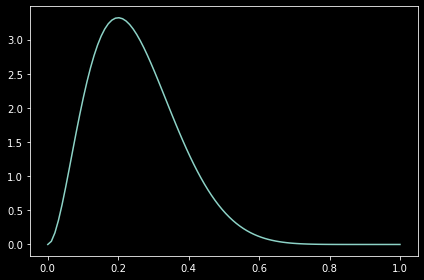

In [71]:
click = 2
recomm = 10

#alpha, scipy.stats.beta 대신에 a, b를 사용하겠습니다.
a = click + 1
b = recomm - click + 1

ctr = (a-1) / (a+b-2) #mode
var = (a*b) / ((a+b)**2*(a+b+1)) #var

print(f"ctr : {ctr:.3f} | var : {var:.3f}")

xs = np.linspace(0, 1, 100)
# scipy.stats.beta distribution의 probability density fuction을 정의합니다.
ys = scipy.stats.beta.pdf(xs, a, b)

fig, ax = plt.subplots()

ax.plot(xs,ys)

fig.tight_layout()

#### case 2) 사용자에게 100번의 추천을 했을 때 20번 클릭한 경우

ctr : 0.200 | var : 0.002


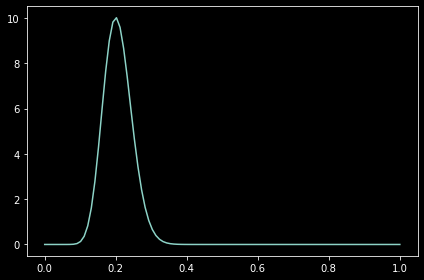

In [72]:
click = 20
recomm = 100

#alpha, scipy.stats.beta 대신에 a, b를 사용하겠습니다.
a = click + 1
b = recomm - click + 1

ctr = (a-1) / (a+b-2) #mode
var = (a*b) / ((a+b)**2*(a+b+1)) #var

print(f"ctr : {ctr:.3f} | var : {var:.3f}")

xs = np.linspace(0, 1, 100)
# scipy.stats.beta distribution의 probability density fuction을 정의합니다.
ys = scipy.stats.beta.pdf(xs, a, b)

fig, ax = plt.subplots()

ax.plot(xs,ys)

fig.tight_layout()

#### case 3) 사용자에게 1000번의 추천을 했을 때 200번 클릭한 경우

ctr : 0.200 | var : 0.000


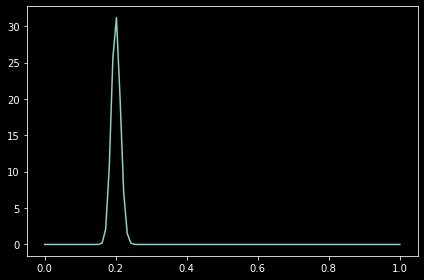

In [73]:
click = 200
recomm = 1000

#alpha, scipy.stats.beta 대신에 a, b를 사용하겠습니다.
a = click + 1
b = recomm - click + 1

ctr = (a-1) / (a+b-2) #mode
var = (a*b) / ((a+b)**2*(a+b+1)) #var

print(f"ctr : {ctr:.3f} | var : {var:.3f}")

xs = np.linspace(0, 1, 100)
# scipy.stats.beta distribution의 probability density fuction을 정의합니다.
ys = scipy.stats.beta.pdf(xs, a, b)

fig, ax = plt.subplots()

ax.plot(xs,ys)

fig.tight_layout()